<a href="https://colab.research.google.com/github/tayalkshitij/multimodal-exploration/blob/main/image_captioning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -U timm # library of pretrained image model
!pip install -U albumentations # images modification and resize to uniform size

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 15.2 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylin

<body>
    <h1>Tutorial: Image Captioning</h1>
    <p>Author(s):</p>
    <ul>
        <li>Kshitij Tayal, Oak Ridge National Labs, <a href="mailto:tayalk@ornl.gov">tayalk@ornl.gov</a></li>
    </ul>
    <p>In this tutorial, we will learn a image captioning model, which will generate caption for a given image with an end-to-end transformer network.
    </p>
</body>

# Setting Up Dependency

In [ ]:
import cv2
import pandas as pd
import torch
import torch.nn as nn
import torchtext
import timm
import albumentations as alb
from albumentations import Compose
from albumentations.pytorch import ToTensorV2
from collections import Counter
from torch.utils.data import DataLoader, Dataset
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import Vocab

# Set the device to GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# Table of Contents


*   [Overview](#overview)
*   [Climate Impact](#climate-impact)
*   [Target Audience](#target-audience)
*   [Background & Prerequisites](#background-and-prereqs)
*   [Software Requirements](#software-requirements)
*   [Data Description](#data-description)
*   [Methodology & Results](#methodology)
*   [Discussion](#results-and-discussion)
*   [References](#references)


<a name="overview"></a>
# Overview
<center>
  <img src="https://raw.githubusercontent.com/tayalkshitij/ImageCaptioning/main/images/transformer_architecture.png" width="700">
  <div>Transformer Network Architecture. Source: <a href="https://python.plainenglish.io/image-captioning-with-an-end-to-end-transformer-network-8f39e1438cd4">Medium </a></div>
</center>

#Image Captioning Architecture:
<center>
  <img src="https://raw.githubusercontent.com/tayalkshitij/ImageCaptioning/main/images/image_captioning_model.png" width="700">
  <div>Image Captioning Model. Source: <a href="https://arxiv.org/abs/2101.10804">CPTR: Full Transformer Network for Image Captioning </a></div>
</center>

#Intro to Multimodal AI and Encoder-Decoders

<a name="Data Description"></a>
# Data Description

The Flickr8K dataset is a well-known benchmark dataset in the field of image captioning and computer vision. It consists of 8,000 images sourced from the Flickr website, which depict a variety of scenes involving humans and animals performing different activities in diverse environments. Each image in the dataset is accompanied by five different captions, which were written by human annotators. These captions describe the activities, objects, and scene details captured in the images.
The diverse nature of the images and the detailed descriptions help in training models to understand and generate nuanced text descriptions of visual content.

## Loading in Image Caption Dataset

In [ ]:
from google.colab import drive
from google.colab.patches import cv2_imshow

# Mount Google Drive to access the dataset stored there
# Dataset downloaded from https://www.kaggle.com/datasets/adityajn105/flickr8k
drive.mount('/content/drive')
%cd "/content/drive/My Drive/Flickr8kVersion"

# File containing image captions
caption_filename = 'captions.txt'

# Initialize structures to store captions
#For every image, we have 5 captions
captions_dict = {}
all_captions = []

with open(caption_filename) as captions:
  lines = captions.readlines()

# Process each line in the file
# Skip the header
for line in lines[1:]:
    # Remove trailing newline character and split on delimiter
    image_id, caption = line.rstrip('\n').split('.jpg,') # split into image file name and caption
    image_id += '.jpg'  # Append the file extension to maintain original format

    # Skip empty image ids
    if not image_id:
        continue

    # Append the caption to the list of captions for the current image
    if image_id in captions_dict:
        captions_dict[image_id].append(caption)
    else:
        captions_dict[image_id] = [caption]

    # Collect all captions in a single list
    all_captions.append(caption)

Mounted at /content/drive
/content/drive/My Drive/Flickr8kVersion


In [ ]:
# Printing samples from the dictionary and the list
print("Sample entries from captions_dict:")
for image_id, captions in list(captions_dict.items())[:5]:  # Print the first 5 entries
    print(f"{image_id}: {captions}")

print("\nSample captions from all_captions:")
for caption in all_captions[:5]:  # Print the first 5 captions
    print(caption)

Sample entries from captions_dict:
1000268201_693b08cb0e.jpg: ['A child in a pink dress is climbing up a set of stairs in an entry way .', 'A girl going into a wooden building .', 'A little girl climbing into a wooden playhouse .', 'A little girl climbing the stairs to her playhouse .', 'A little girl in a pink dress going into a wooden cabin .']
1001773457_577c3a7d70.jpg: ['A black dog and a spotted dog are fighting', 'A black dog and a tri-colored dog playing with each other on the road .', 'A black dog and a white dog with brown spots are staring at each other in the street .', 'Two dogs of different breeds looking at each other on the road .', 'Two dogs on pavement moving toward each other .']
1002674143_1b742ab4b8.jpg: ['A little girl covered in paint sits in front of a painted rainbow with her hands in a bowl .', 'A little girl is sitting in front of a large painted rainbow .', 'A small girl in the grass plays with fingerpaints in front of a white canvas with a rainbow on it .', 

In [ ]:
df = pd.DataFrame(list(captions_dict.items()), columns=['filename', 'captions'])
df

,filename,captions
0,1000268201_693b08cb0e.jpg,[A child in a pink dress is climbing up a set ...
1,1001773457_577c3a7d70.jpg,"[A black dog and a spotted dog are fighting, A..."
2,1002674143_1b742ab4b8.jpg,[A little girl covered in paint sits in front ...
3,1003163366_44323f5815.jpg,[A man lays on a bench while his dog sits by h...
4,1007129816_e794419615.jpg,[A man in an orange hat starring at something ...
...,...,...
8086,990890291_afc72be141.jpg,[A man does a wheelie on his bicycle on the si...
8087,99171998_7cc800ceef.jpg,"[A group is sitting around a snowy crevasse .,..."
8088,99679241_adc853a5c0.jpg,[A grey bird stands majestically on a beach wh...
8089,997338199_7343367d7f.jpg,"[A person stands near golden walls ., a woman ..."


#Setting up Vocabulary

In [ ]:
# Prepare vocabulary
vocab_frequency = Counter()
word_tokenizer = get_tokenizer('basic_english')
for caps in df['captions']:  # Assuming 'caps' is a list of strings
    for cap in caps:
        vocab_frequency.update(word_tokenizer(cap))

In [ ]:
# Printing samples from the vocab_frequency
print("Sample entries from vocab_frequency:")
for word, frequency in list(vocab_frequency.items())[:5]:  # Print the first 5 entries
    print(f"{word}: {frequency}")


Sample entries from vocab_frequency:
a: 62987
child: 1545
in: 18974
pink: 735
dress: 348


In [ ]:
# creates a Vocab object from the vocab_frequency Counter using TorchText,used for processing text data in PyTorch.
vocabulary = torchtext.vocab.vocab(vocab_frequency)
vocabulary_dict = dict(vocabulary.get_stoi())


print(vocabulary_dict)
vocabulary.insert_token('<UNKNOWN>',0)
vocabulary.insert_token('<PAD>',1)
vocabulary.insert_token('<START>',2)
vocabulary.insert_token('<END>',3)
vocabulary.set_default_index(0)

itos = {idx: word for word, idx in vocabulary.get_stoi().items()} # convert index to string


word='<PAD>'
print(f'Index of {word} :{vocabulary[word]}, and frequency is {vocab_frequency[word]}' )
word='child'
print(f'Index of {word} :{vocabulary[word]}, and frequency is {vocab_frequency[word]}' )
word='<START>'
print(f'Index of {word} :{vocabulary[word]}, and frequency is {vocab_frequency[word]}' )

{'patterns': 8910, 'scrolled': 8909, 'weight': 8907, 'dumbbell': 8906, 'spaniels': 8905, 'cocker': 8904, 'breezeway': 8903, 'swatting': 8900, 'wake-board': 8893, 'driftrood': 8890, 'slat': 8889, 'nest': 8887, 'cresting': 8882, 'waterline': 8881, 'atm': 8878, 'slouched': 8877, 'hot-pink': 8876, 'broad': 8873, 'long-bearded': 8872, 'waterproof': 8868, 'buddy': 8867, 'white-footed': 8864, 'lawnmower': 8862, 'healthy': 8861, 'croc': 8860, 'outfield': 8857, 'attampts': 8854, 'gaurd': 8853, 'wedgie': 8852, 'yarn': 8848, 'cruisship': 8846, 'wide-brimmed': 8843, 'tinkerbell': 8842, 'rock-climbs': 8870, 'rugs': 8840, 'paneling': 8837, '1950s': 8830, 'spitting': 8828, 'bedroll': 8827, 'lingers': 8826, 'powerlines': 8825, 'redhead': 8824, 'silohuetted': 8823, 'frustrated': 8822, 'jello': 8820, 'highchair': 8819, 'convienience': 8816, 'convienance': 8813, 'algae': 8808, 'frisbree': 8800, 'dunked': 8798, 'customers': 8793, 'shiner': 8792, 'shine': 8790, 'footrace': 8788, 'angles': 8787, 'viewfinder

# Image Augmentation and Caption Processing

In [ ]:
# Dataset and DataLoader
# The Dataset class encapsulates the training data. It has three primary methods:
# 1. __init__ - Initializes the dataset object, typically loading data files.
# 2. __len__ - Returns the total number of items in the dataset.
# 3. __getitem__(idx) - Retrieves the data sample at a specific index (idx).

# The DataLoader class is used to efficiently iterate over datasets. It supports automatic batching,
# sampling, shuffling, and multiprocess data loading. Here is how it works:
# - It takes a Dataset object as input and generates batches of data from it.
# - It simplifies the process of fetching data samples in parallel, improving training speed.

# For more details on how to use these classes, refer to the PyTorch documentation:
# https://pytorch.org/text/stable/data_utils.html

class ImageCaptionDataset(Dataset):
  def __init__(self, split, df, vocabulary, image_folder='Images/', img_size=224):
    self.df = df
    self.vocabulary = vocabulary
    self.image_folder = image_folder
    self.img_size = img_size
    self.context_length = 20

      # Define transformations
    transformation_list = [
        alb.Resize(self.img_size, self.img_size),
        alb.Normalize()
    ]
    if split == 'training':
        transformation_list.extend([
            alb.HorizontalFlip(),
            alb.ColorJitter()
        ])
    transformation_list.append(ToTensorV2())
    self.transformations = alb.Compose(transformation_list)

  def __len__(self):
        return len(self.df)

  def __getitem__(self, idx):
      image_filename, captions = self.df.iloc[idx]
      actual_image = cv2.cvtColor(cv2.imread(self.image_folder + image_filename), cv2.COLOR_BGR2RGB)
      transformed_img = self.transformations(image=actual_image)['image']

      encoded_captions = []
      for cap in captions:
          splitted = word_tokenizer(cap)
          integers = [self.vocabulary[token] for token in splitted]
          integers = [2] + integers + [3]  # Add START and END tokens

          if len(integers) < self.context_length:
              integers += [1] * (self.context_length - len(integers))  # Pad with <PAD>
          else:
              integers = integers[:self.context_length - 1] + [3]  # Ensure correct length

          encoded_captions.append(torch.tensor(integers, dtype=torch.long))

      random_idx = torch.randint(len(encoded_captions), (1,)).item() # randomly choose 1 of the caption
      return transformed_img, encoded_captions[random_idx]


Batch image shape: torch.Size([32, 3, 224, 224]) (e.g., [batch_size, channels, height, width])
Batch caption shape: torch.Size([32, 20]) (e.g., [batch_size, sequence_length])
Caption indices at position 1: tensor([   2,    4,  200,   13,  447,  354,    6,    4,  209,   94,  597,   32,
        1627,   18,    3,    1,    1,    1,    1,    1])


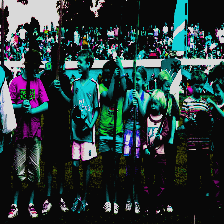

Decoded caption: <START> a group of kids stand in a row holding sticks and swords . <END> <PAD> <PAD> <PAD> <PAD> <PAD>


In [ ]:
# Example of using the dataset
training_dataset = ImageCaptionDataset('training', df, vocabulary)
training_data = DataLoader(training_dataset, batch_size=32, shuffle=True)

# Example of iterating over the DataLoader
for image, caption in training_data:
    # Print the shape of image and caption tensors for the current batch
    print(f"Batch image shape: {image.shape} (e.g., [batch_size, channels, height, width])")
    print(f"Batch caption shape: {caption.shape} (e.g., [batch_size, sequence_length])")

    # Choose a random index within the batch (here, the second item is chosen)
    rand_indx = 1

    # Display the indices in the caption at rand_indx
    print(f"Caption indices at position {rand_indx}: {caption[rand_indx,:]}")

    # Convert the selected image to numpy array, permute dimensions, and scale pixel values
    image_np = (image[rand_indx].permute(1, 2, 0).detach().cpu().numpy() * 255).astype('uint8')

    # Display the image using OpenCV
    cv2_imshow(image_np)

    # Convert caption indices to words using the itos mapping, handling unknown indices
    words = [itos[index] if index < len(itos) else '<UNKNOWN>' for index in caption[rand_indx].numpy()]

    # Print the actual caption by joining the words
    print("Decoded caption:", ' '.join(words))

    # Break after the first batch to keep the output brief
    break

# Implementing Neural Network Layers

<body>
    <p>This class, performs image captioning by combining CNNs and transformers.</p>
    <h2>Initialization</h2>
    <ul>
        <li><strong>CNN Encoder:</strong> Uses EfficientNet B0 pre-trained on ImageNet to extract image features.</li>
        <li><strong>Feature Projection:</strong> Projects CNN features to a transformer-compatible dimension.</li>
        <li><strong>Word and Position Embeddings:</strong> Converts words and positions into dense vectors.</li>
        <li><strong>Transformer Decoder:</strong> A series of transformer decoder layers to process text sequentially.</li>
        <li><strong>Output Projection:</strong> Projects transformer output back to vocabulary space.</li>
    </ul>
    <h2>Forward Pass</h2>
    <ul>
        <li><strong>Embedding Combination:</strong> Combines word and positional embeddings for transformer input.</li>
        <li><strong>Image Encoding:</strong> Encodes images using CNN and a projection layer to fit transformer input.</li>
        <li><strong>Transformer Processing:</strong> Processes embeddings and encoded images with attention mechanisms.</li>
        <li><strong>Vocabulary Output:</strong> Converts transformer outputs into vocabulary probability distributions.</li>
    </ul>
</body>

In [ ]:
# Define a class for an Image Captioning model based on a neural network architecture
class ImageCaptioner(nn.Module):
    def __init__(self, context_length, vocabulary_size, num_blocks, model_dim, num_heads, dropout_prob):
        super().__init__()

        # Initialize a CNN encoder using a pre-trained EfficientNet B0
        self.cnn_encoder = timm.create_model('efficientnet_b0', pretrained=True)

        # Create a dummy image to compute the input features' dimension
        dummy_image = torch.zeros(1, 3, 224, 224)  # Batch size 1, 3 color channels, 224x224 dimensions

        # Pass the dummy image through the encoder to determine the output features' dimension
        with torch.no_grad():
            cnn_output = self.cnn_encoder(dummy_image)

        in_features = cnn_output.shape[1]  # Get the number of output features from the CNN encoder

        # Linear layer to project CNN features to the dimension expected by the transformer decoder
        self.feature_projection = nn.Linear(in_features, model_dim)

        # Embedding layer for transforming vocabulary indices into vectors
        self.word_embedding = nn.Embedding(vocabulary_size, model_dim)

        # Positional embedding layer for adding position information to token embeddings
        self.position_embedding = nn.Embedding(context_length, model_dim)

        # Define a single Transformer decoder layer
        transformer_decoder_layer = nn.TransformerDecoderLayer(
            model_dim, num_heads, 2 * model_dim, dropout=dropout_prob, batch_first=True, norm_first=True
        )

        # Stack multiple transformer decoder layers to form the decoder
        self.transformer_decoder = nn.TransformerDecoder(transformer_decoder_layer, num_blocks)

        # Linear layer to project the output of the transformer decoder back to vocabulary space
        self.vocab_projection = nn.Linear(model_dim, vocabulary_size)

    def forward(self, images, true_labels):
        # Embedding tokens and positions
        token_embeddings = self.word_embedding(true_labels)
        batch_size, sequence_length = true_labels.shape

        # Generate position indices and obtain their embeddings
        positions = torch.arange(sequence_length).to(images.device)
        position_embeddings = self.position_embedding(positions)

        # Combine token and position embeddings
        total_embeddings = token_embeddings + position_embeddings

        # Encode the image and prepare it for attention mechanism in the transformer decoder
        with torch.no_grad():
            encoded_image = self.feature_projection(self.cnn_encoder(images).view(batch_size, -1))

        # Unsqueeze to add an extra dimension for compatibility with transformer inputs
        image_features_for_attention = torch.unsqueeze(encoded_image, 1)

        # Generate a mask for preventing attention to future tokens
        attention_mask = nn.Transformer.generate_square_subsequent_mask(sequence_length).to(images.device)

        # Process embeddings through the transformer decoder
        decoder_output = self.transformer_decoder(total_embeddings, image_features_for_attention, tgt_mask=attention_mask)

        # Project the output of the transformer to vocabulary size
        vocabulary_output = self.vocab_projection(decoder_output)

        return vocabulary_output




In [ ]:
# Set up the context length, which dictates the maximum sequence of tokens the model will handle
context_length = 20

# Calculate the vocabulary size from the vocabulary set
# This is the total number of unique tokens that can be embedded
vocabulary_size = len(vocabulary)  # number of rows in Token Embedding Table

# Define the number of transformer blocks in the model
num_blocks = 6

# Set the dimension of the model embeddings and outputs
model_dim = 512

# Define the number of attention heads in each transformer block
# Each head will have a size of model_dim / num_heads, which should be an integer
num_heads = 16  # model_dim / num_heads should not have a denominator #head_size = 512/16

# Set the dropout probability to prevent overfitting during training
dropout_probability = 0.5

# Initialize the image captioning model with specified parameters and move it to the computing device
model = ImageCaptioner(context_length, vocabulary_size, num_blocks, model_dim, num_heads, dropout_probability).to(device)


# Freeze the parameters in the CNN encoder to prevent them from being updated during training
for layer in model.cnn_encoder.parameters():
    layer.requires_grad = False  # This disables training for the CNN part

# Set up the loss function using cross-entropy loss, ignoring the padding index
# The '<PAD>' token is used for padding shorter sentences to maintain uniform length
loss_function = nn.CrossEntropyLoss(ignore_index=vocabulary['<PAD>'])


# Define the optimizer to update the model parameters, using AdamW algorithm with a specified learning rate
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

In [ ]:
# Set the number of epochs for training
num_epochs = 1

# Initialize a counter to keep track of the number of iterations (or batches processed)
num_iterations = 0

# Begin the training process over multiple epochs
for epoch in range(num_epochs):
    # Iterate over each batch of images and captions in the training dataset
    for images, captions in training_data:
        # Move the images and captions to the appropriate device (CPU or GPU)
        images, captions = images.to(device), captions.to(device)

        # Extract batch size (B) and sequence length (T) from captions,  #B, 3, 224, 224 -> images #B,T -> captions
        batch_size, sequence_length = captions.shape

        # Generate model predictions for the current batch
        # model(images, captions) outputs logits of shape [B, T, V] where V is vocabulary size
        model_prediction = model(images, captions)

        # Reshape model output to fit the loss function requirements: [B*T, V]
        model_prediction = model_prediction.view(batch_size * sequence_length, -1)

        # Compute the loss between the model predictions and the true captions
        # Reshape captions to be a flat vector of length B*T
        loss = loss_function(model_prediction, captions.view(batch_size * sequence_length))

        # Perform backpropagation to calculate gradients
        loss.backward()

        # Clip gradients to a maximum norm of 2.0 to prevent exploding gradients
        nn.utils.clip_grad_norm_(model.parameters(), 2.0)

        # Update the model parameters based on the gradients calculated
        optimizer.step()

        # Clear the gradients after updating the parameters
        optimizer.zero_grad()

        # Print the loss periodically after every 100 iterations
        if num_iterations % 100 == 0:
            print(f"Loss after {num_iterations} iterations is: {loss.item()}")

        # Increment the iteration counter
        num_iterations += 1


    model_prediction = model(images, captions) # B, T, V
    model_prediction = model_prediction.view(B*T,V)
    loss = loss_function(model_prediction, captions.view(B*T))
    loss.backward() # calculate gradients
    nn.utils.clip_grad_norm_(model.parameters(), 2.0) # prevent exploding gradient
    optimizer.step() # use gradients to update parameters
    if num_iterations %100 ==0:
      print (loss.item())
    num_iterations +=1



Loss after 0 iterations is: 10.580008506774902


KeyboardInterrupt: 

In [ ]:
integer_to_word = vocabulary_mapping.get_itos()
num_iterations = 0
for epoch in range(num_epochs):
  for x, y in training_data:
    x, y = x.to(device), y.to(device)
    B,T = captions.shape
    #B, 3, 224, 224 -> images
    #B,T -> captions
    prediction = model(x, y) # B, T, Vocab_size
    _, indices = torch.max(prediction, dim=-1) # B,T higest prob along Vocab dimesnion
    first_caption = indices[0]
    sentence = []
    for id in first_caption:
      sentence.append(integer_to_word[id])
      if id ==3: # End Token
        break
    print (' '.join(sentence))

    B,T, Vocab_Size = prediction.shape
    prediction = prediction.view(B*T,Vocab_size)

    loss = loss_function(prediction, y.view(B*T))
    loss.backward() # calculate gradients
    nn.utils.clip_grad_norm_(model.parameters(), 2.0) # prevent exploding gradient
    optimizer.step() # use gradients to update parameters
    if num_iterations %100 ==0:
      print (loss.item())
    num_iterations +=1

In [ ]:
torch.save(model.state_dict(), 'weights.pt')
from google.colab import files
files.download('weights.pt')

In [ ]:
model.load_state_dict(torch.load('/content/hella epochs.pt'))

In [ ]:
Translation.
audio to text
